# FINAL

## Prep

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Fall24/IS734/IS734 Project/Phishing_URL_Detection.csv')

In [44]:
df.shape

(11055, 31)

In [45]:
df.head() #0 IS SUSPICIOUS, 1 IS LEGITIMATE, -1 IS PHISHING

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [46]:
df = df.replace(-1, 0)

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score, f1_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
url_based_features = [
    'SSLfinal_State',
    'having_Sub_Domain',
    'Prefix_Suffix',
    'having_IP_Address',
    'URL_Length',
    'HTTPS_token',
    'having_At_Symbol',
    'Shortining_Service',
    'double_slash_redirecting',
    'port',
    'Abnormal_URL',
    'Redirect',
    'Result'
]

content_based_features = [
    'URL_of_Anchor',
    'Domain_registeration_length',
    'web_traffic',
    'Request_URL',
    'Links_in_tags',
    'SFH',
    'Submitting_to_email',
    'age_of_domain',
    'DNSRecord',
    'Page_Rank',
    'Google_Index',
    'Links_pointing_to_page',
    'Statistical_report',
    'on_mouseover',
    'RightClick',
    'Favicon',
    'popUpWidnow',
    'Iframe',
    'Result'
]

In [49]:
!pip install tldextract==3.4.0

In [50]:
!pip install python-whois

In [51]:
import whois
import datetime
import tldextract
import pandas as pd
import re

In [52]:
import requests
def get_ssl_final_state(url):
        try:
            response = requests.get(url, verify=True, timeout=5)  # Set timeout to prevent long waits
            if response.ok:  # Check if connection was successful
                return 1  # Valid certificate
            else:
                return 0  # Invalid or suspicious certificate
        except requests.exceptions.SSLError:
            return 0  # Invalid or suspicious certificate
        except requests.exceptions.RequestException:
            return 0  # Connection error (likely no certificate)


import re

def get_having_sub_domain(url):
    try:
        domain_match = re.search(r'://(?:www\.)?([^/]+)', url)
        if domain_match:
            domain = domain_match.group(1)
            num_subdomains = len(domain.split('.')) - 2  # -2 to exclude main domain and TLD

            if num_subdomains == 0:
                return 1
            elif num_subdomains == 1:
                return 1  # Legitimate subdomain
            else:
                return 0  # Suspicious or multiple subdomains
        else:
            return 0  # Invalid URL format
    except:
        return 0  # Error handling for unexpected cases

import re

def get_prefix_suffix(url):

    if re.search(r'-', url):
        return 0

    if re.search(r'\.(php|html?)$', url, re.IGNORECASE):
        return 0

    return 1




import re


def get_domain_length(url):
  try:
    domain_match = re.search(r'://(?:www\.)?([^/]+)', url)
    if domain_match:
      domain = domain_match.group(1)
      return len(domain)
    else:
      return 0
  except:
    return 0

def get_having_ip_address(url):
    match = re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url)
    return 0 if match else 1

def get_url_length(url):
    return 1 if len(url) < 54 else 0

def get_https_token(url):
    return 1 if url.startswith('https') else 0

def get_having_at_symbol(url):
    return 1 if '@' in url else 0


import re

def get_shortening_service(url):
    shortening_services = ["bit.ly", "goo.gl", "tinyurl.com", "ow.ly", "t.co", "is.gd"]

    domain = re.search(r'://(?:www\.)?([^/]+)', url).group(1) if re.search(r'://(?:www\.)?([^/]+)', url) else None

    if domain and any(service in domain for service in shortening_services):
        return 0
    else:
        return 1

def get_double_slash_redirecting(url):
    if re.search(r':////', url):
        return 0
    else:
        return 1

def get_port(url):
    port_match = re.search(r':(\d+)$', url)

    if port_match:
        port = int(port_match.group(1))
        if port != 80 and port != 443:
            return 0
        else:
            return 1
    else:
        return 1

def get_abnormal_url(url):
    if not re.match(r'^https?://', url):
        return 0
    else:
        return 1

def get_redirect(url):

    redirect_keywords = ["redirect", "url=", "link=", "dest="]
    if any(keyword in url.lower() for keyword in redirect_keywords):
        return 0
    else:
        return 1

import whois
import datetime
import tldextract

def get_domain_age_in_years(domain_name):
  try:
    tld = tldextract.extract(domain_name).suffix

    domain = whois.whois(domain_name)

    if domain:
      creation_date = domain.creation_date
      if isinstance(creation_date, list):
          creation_date = creation_date[0]
      today = datetime.datetime.now()
      age = today - creation_date
      age_in_years = age.days / 365.25
      return 1 if age_in_years > 2 else 0
    else:
      #print('Could not retrieve whois information')
      return 0

  except Exception as e:
    #print(f"Error retrieving domain age for {domain_name}: {e}")
    return 0

In [53]:
import pandas as pd
import re

def feature_engineering(df):
    df['SSLfinal_State'] = df['URL'].apply(get_ssl_final_state)
    df['having_Sub_Domain'] = df['URL'].apply(get_having_sub_domain)
    df['Prefix_Suffix'] = df['URL'].apply(get_prefix_suffix)
    df['having_IP_Address'] = df['URL'].apply(get_having_ip_address)
    df['URL_Length'] = df['URL'].apply(get_url_length)
    df['HTTPS_token'] = df['URL'].apply(get_https_token)
    df['having_At_Symbol'] = df['URL'].apply(get_having_at_symbol)
    df['Shortining_Service'] = df['URL'].apply(get_shortening_service)
    df['double_slash_redirecting'] = df['URL'].apply(get_double_slash_redirecting)
    df['port'] = df['URL'].apply(get_port)
    df['Abnormal_URL'] = df['URL'].apply(get_abnormal_url)
    df['Redirect'] = df['URL'].apply(get_redirect)
    return df


## Modelling

In [14]:
def create_model():
  nb = GaussianNB()
  dtc = DecisionTreeClassifier(
      max_depth=5,
      min_samples_split=10,
      min_samples_leaf=5,
      random_state=42
  )
  rf = RandomForestClassifier()
  lr = LogisticRegression(max_iter=1000, random_state=42)
  svm = SVC(kernel='linear', random_state=42)
  return nb, dtc, rf, lr, svm


In [15]:
def splitdata(df):
  X = df.drop(columns=['Result'], axis=1)
  y = df['Result']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [22]:
def fit_model(X_train,y_train):
  nb.fit(X_train, y_train)
  dtc.fit(X_train, y_train)
  rf.fit(X_train, y_train)
  lr.fit(X_train, y_train)
  svm.fit(X_train, y_train)
  return nb, dtc, rf, lr, svm

In [16]:
def predict(X_test):
  y_pred_nb = nb.predict(X_test)
  y_pred_dtc = dtc.predict(X_test)
  y_pred_rf = rf.predict(X_test)
  y_pred_lr = lr.predict(X_test)
  y_pred_svm = svm.predict(X_test)
  return y_pred_nb,y_pred_dtc,y_pred_rf,y_pred_lr,y_pred_svm

In [17]:
def accuracy(y_test):
  print("Accuracy Scores:")
  print("Naive Bayes:", accuracy_score(y_test, y_pred_nb))
  print("Decision Tree:", accuracy_score(y_test, y_pred_dtc))
  print("Random Forest:", accuracy_score(y_test, y_pred_rf))
  print("Logistic Regression:", accuracy_score(y_test, y_pred_lr))
  print("SVM:", accuracy_score(y_test, y_pred_svm))

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [20]:
df_url = df[url_based_features]
df_content = df[content_based_features]

## Testing

In [54]:
print('URL Based Features')
nb, dtc, rf, lr, svm = create_model()
X_train, X_test, y_train, y_test = splitdata(df_url)
nb, dtc, rf, lr, svm = fit_model(X_train,y_train)
y_pred_nb_url,y_pred_dtc_url,y_pred_rf_url,y_pred_lr_url,y_pred_svm_url = predict(X_test)
accuracy(y_test)

URL Based Features
Accuracy Scores:
Naive Bayes: 0.6910900045228403
Decision Tree: 0.9095431931252826
Random Forest: 0.947535052012664
Logistic Regression: 0.9167797376752601
SVM: 0.9167797376752601


In [55]:
print('Content Based Features')
nb, dtc, rf, lr, svm = create_model()
X_train, X_test, y_train, y_test = splitdata(df_content)
nb, dtc, rf, lr, svm = fit_model(X_train,y_train)
y_pred_nb_content,y_pred_dtc_content,y_pred_rf_content,y_pred_lr_content,y_pred_svm_content = predict(X_test)
accuracy(y_test)

Content Based Features
Accuracy Scores:
Naive Bayes: 0.6910900045228403
Decision Tree: 0.9095431931252826
Random Forest: 0.947535052012664
Logistic Regression: 0.9167797376752601
SVM: 0.9167797376752601


In [56]:
print('Combined Features')
nb, dtc, rf, lr, svm = create_model()
X_train, X_test, y_train, y_test = splitdata(df)
nb, dtc, rf, lr, svm = fit_model(X_train,y_train)
y_pred_nb_combined,y_pred_dtc_combined,y_pred_rf_combined,y_pred_lr_combined,y_pred_svm_combined = predict(X_test)
accuracy(y_test)

Combined Features
Accuracy Scores:
Naive Bayes: 0.6910900045228403
Decision Tree: 0.9095431931252826
Random Forest: 0.947535052012664
Logistic Regression: 0.9167797376752601
SVM: 0.9167797376752601


## Results

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
accuracy_scores = {
    'Model': ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM'],
    'Accuracy': [accuracy_score(y_test, y_pred_nb_url),accuracy_score(y_test, y_pred_dtc_url),accuracy_score(y_test, y_pred_rf_url),accuracy_score(y_test, y_pred_lr_url),accuracy_score(y_test, y_pred_svm_url)]
}

accuracy_table = pd.DataFrame(accuracy_scores)


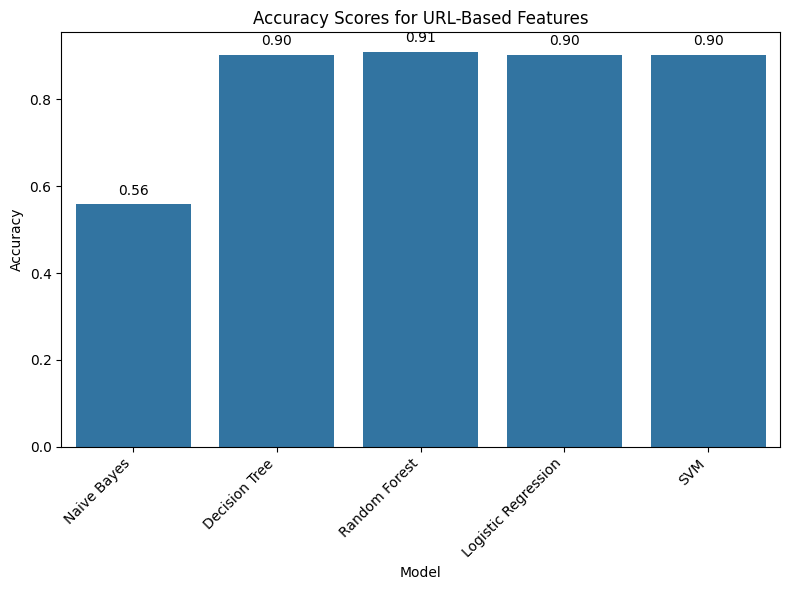

In [58]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=accuracy_table)
plt.title('Accuracy Scores for URL-Based Features')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.tight_layout()

In [59]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

report = classification_report(y_test, y_pred_rf_url, output_dict=True, target_names=['Phishing', 'Legitimate'])
cr = pd.DataFrame(report).transpose()

display(cr.style.background_gradient(cmap='Blues'))

,precision,recall,f1-score,support
Phishing,0.923681,0.860879,0.891175,956.000000
Legitimate,0.899242,0.945817,0.921942,1255.000000
accuracy,0.909091,0.909091,0.909091,0.909091
macro avg,0.911462,0.903348,0.906558,2211.000000
weighted avg,0.909809,0.909091,0.908639,2211.000000


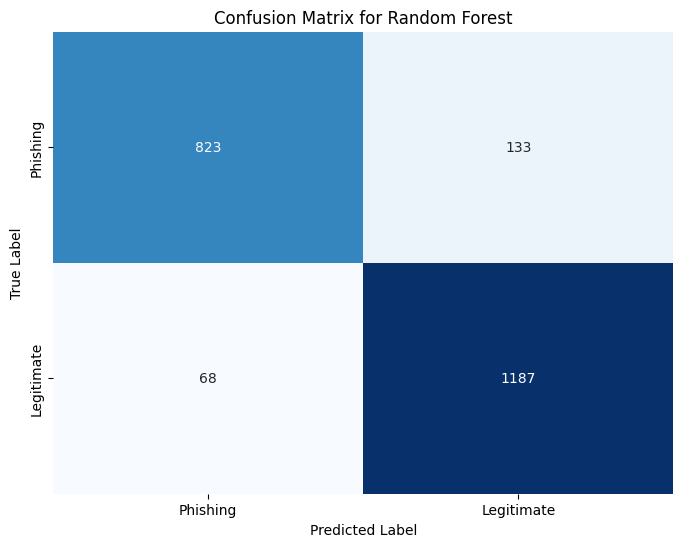

In [60]:
cm = confusion_matrix(y_test, y_pred_rf_url)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Phishing', 'Legitimate'],
            yticklabels=['Phishing', 'Legitimate'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score

accuracy_scores = {
    'Model': ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM'],
    'Accuracy': [accuracy_score(y_test, y_pred_nb_content), accuracy_score(y_test, y_pred_dtc_content), accuracy_score(y_test, y_pred_rf_content), accuracy_score(y_test, y_pred_lr_content), accuracy_score(y_test, y_pred_svm_content)]
}

accuracy_table = pd.DataFrame(accuracy_scores)


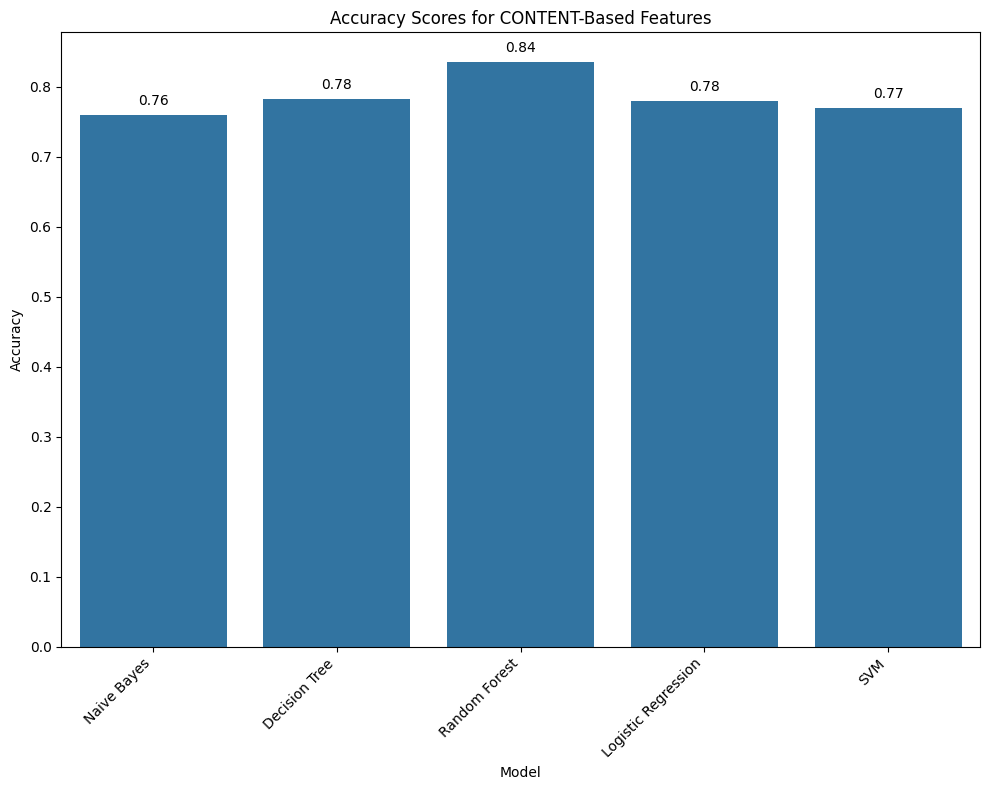

In [62]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='Model', y='Accuracy', data=accuracy_table)
plt.title('Accuracy Scores for CONTENT-Based Features')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.tight_layout()

In [63]:
report = classification_report(y_test, y_pred_rf_content, output_dict=True, target_names=['Phishing', 'Legitimate'])
cr = pd.DataFrame(report).transpose()

display(cr.style.background_gradient(cmap='Blues'))

,precision,recall,f1-score,support
Phishing,0.790607,0.845188,0.816987,956.000000
Legitimate,0.875526,0.829482,0.851882,1255.000000
accuracy,0.836273,0.836273,0.836273,0.836273
macro avg,0.833066,0.837335,0.834435,2211.000000
weighted avg,0.838808,0.836273,0.836794,2211.000000


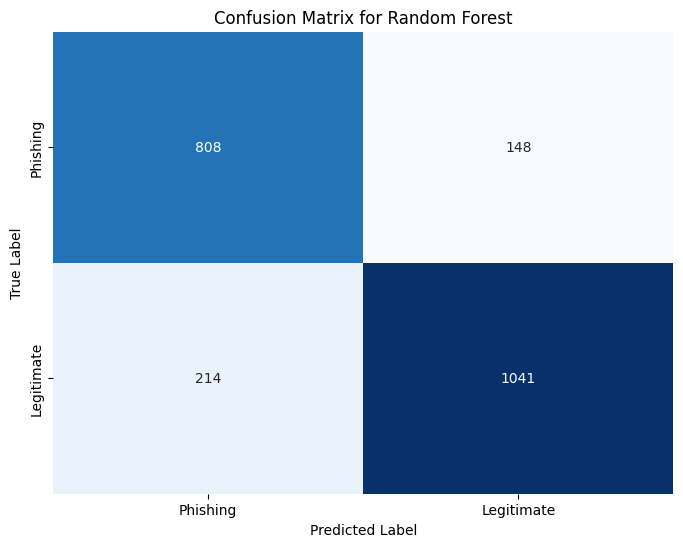

In [64]:
cm = confusion_matrix(y_test, y_pred_rf_content)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Phishing', 'Legitimate'],
            yticklabels=['Phishing', 'Legitimate'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [65]:

accuracy_scores = {
    'Model': ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM'],
    'Accuracy': [accuracy_score(y_test, y_pred_nb_combined), accuracy_score(y_test, y_pred_dtc_combined), accuracy_score(y_test, y_pred_rf_combined), accuracy_score(y_test, y_pred_lr_combined), accuracy_score(y_test, y_pred_svm_combined)]
}

accuracy_table = pd.DataFrame(accuracy_scores)


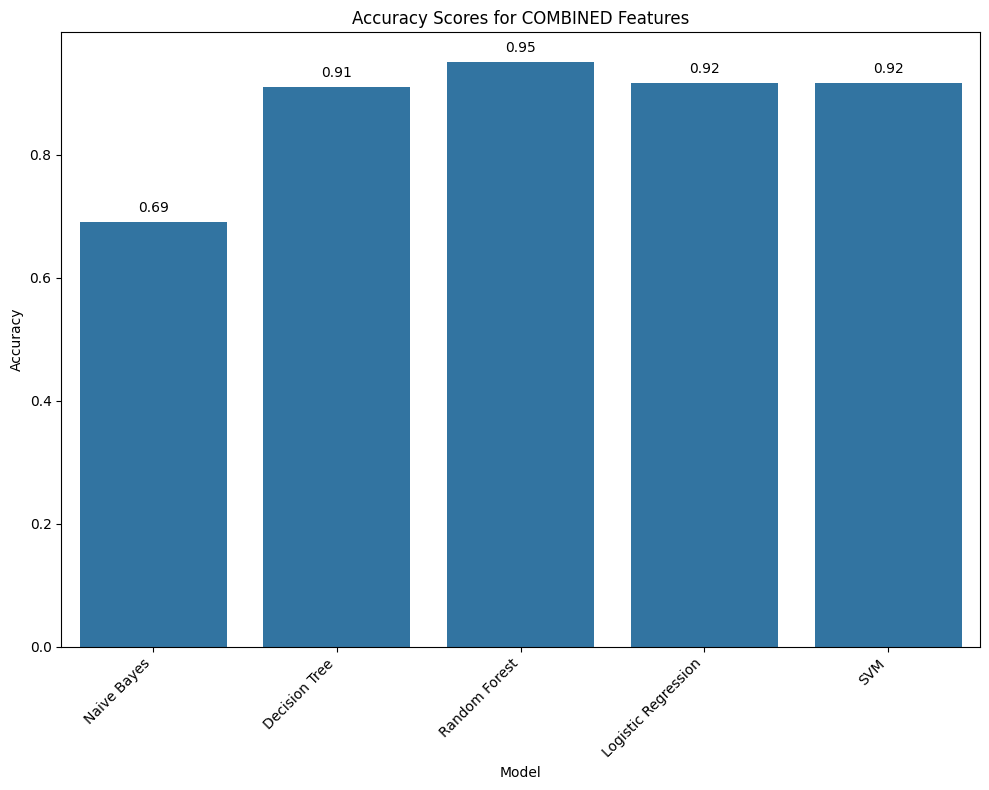

In [66]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='Model', y='Accuracy', data=accuracy_table)
plt.title('Accuracy Scores for COMBINED Features')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.tight_layout()

In [67]:
report = classification_report(y_test, y_pred_rf_combined, output_dict=True, target_names=['Phishing', 'Legitimate'])
cr = pd.DataFrame(report).transpose()

display(cr.style.background_gradient(cmap='Blues'))

,precision,recall,f1-score,support
Phishing,0.947257,0.939331,0.943277,956.000000
Legitimate,0.954078,0.960159,0.957109,1255.000000
accuracy,0.951153,0.951153,0.951153,0.951153
macro avg,0.950667,0.949745,0.950193,2211.000000
weighted avg,0.951129,0.951153,0.951128,2211.000000


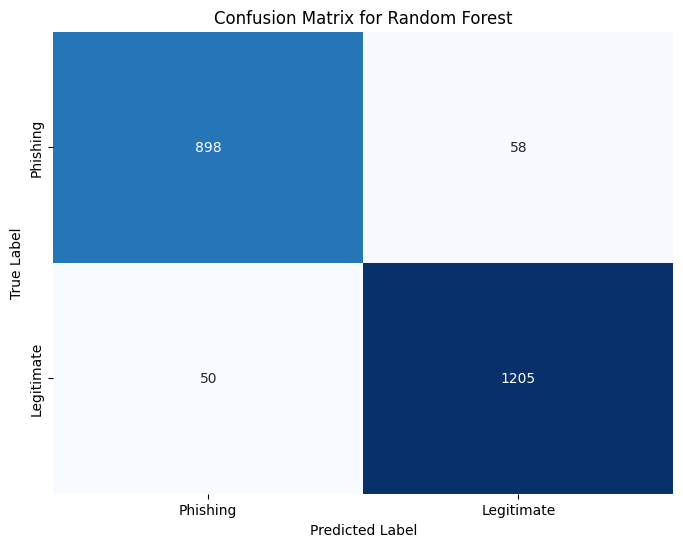

In [68]:
cm = confusion_matrix(y_test, y_pred_rf_combined)

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Phishing', 'Legitimate'],
            yticklabels=['Phishing', 'Legitimate'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [69]:
accuracy_scores = {
    'Model': ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM'],
'URL based features':[accuracy_score(y_test, y_pred_nb_url),accuracy_score(y_test, y_pred_dtc_url),accuracy_score(y_test, y_pred_rf_url),accuracy_score(y_test, y_pred_lr_url),accuracy_score(y_test, y_pred_svm_url)],
   'Content based features':[accuracy_score(y_test, y_pred_nb_content),accuracy_score(y_test, y_pred_dtc_content),accuracy_score(y_test, y_pred_rf_content),accuracy_score(y_test, y_pred_lr_content),accuracy_score(y_test, y_pred_svm_content)],
'Combined features':[accuracy_score(y_test, y_pred_nb_combined),accuracy_score(y_test, y_pred_dtc_combined),accuracy_score(y_test, y_pred_rf_combined),accuracy_score(y_test, y_pred_lr_combined),accuracy_score(y_test, y_pred_svm_combined)]
    }

accuracy_table = pd.DataFrame(accuracy_scores)

print(accuracy_table)

                 Model  URL based features  Content based features  \
0          Naive Bayes            0.558118                0.760289   
1        Decision Tree            0.902307                0.782904   
2        Random Forest            0.909091                0.836273   
3  Logistic Regression            0.902759                0.780642   
4                  SVM            0.902759                0.769787   

   Combined features  
0           0.691090  
1           0.909543  
2           0.951153  
3           0.916780  
4           0.916780  


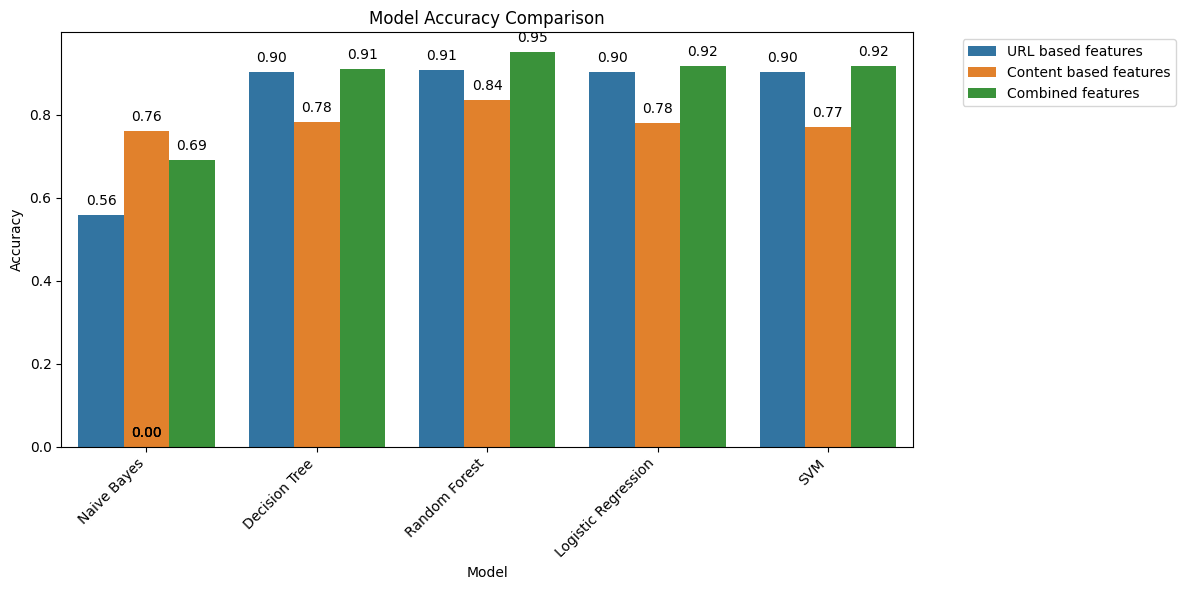

In [70]:

melted_df = pd.melt(accuracy_table, id_vars=['Model'], value_vars=['URL based features', 'Content based features', 'Combined features'], var_name='Feature Type', value_name='Accuracy')


plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='Accuracy', hue='Feature Type', data=melted_df)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.tight_layout()
plt.show()

#Live

In [71]:
nb = GaussianNB()
dtc = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=1000, random_state=42)
svm = SVC(kernel='linear', random_state=42)


In [72]:
X = df_url.drop(columns=['Result'], axis=1)
y = df_url['Result']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
nb.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [75]:
y_pred_nb_url = nb.predict(X_test)
y_pred_dtc_url = dtc.predict(X_test)
y_pred_rf_url = rf.predict(X_test)
y_pred_lr_url = lr.predict(X_test)
y_pred_svm_url = svm.predict(X_test)

In [76]:
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred_rf_url))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       956
           1       0.90      0.95      0.92      1255

    accuracy                           0.91      2211
   macro avg       0.91      0.90      0.91      2211
weighted avg       0.91      0.91      0.91      2211



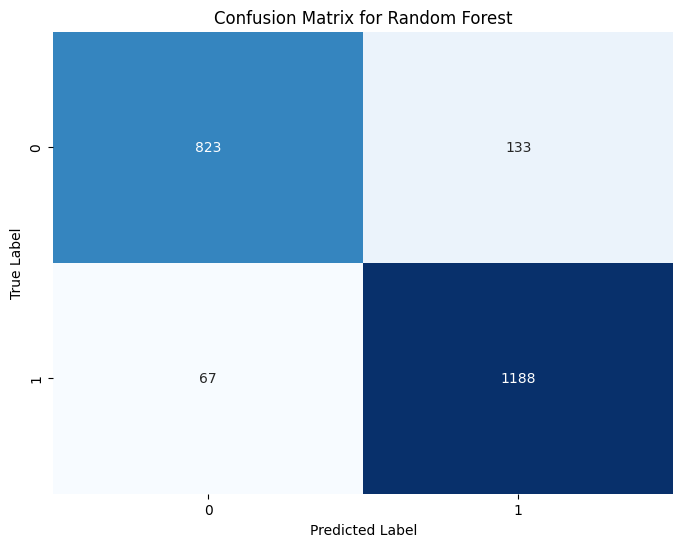

In [77]:

cm = confusion_matrix(y_test, y_pred_rf_url)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [78]:
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df

,Feature,Importance
0,SSLfinal_State,0.694043
1,having_Sub_Domain,0.113502
2,Prefix_Suffix,0.098852
3,having_IP_Address,0.014787
4,URL_Length,0.014390
9,port,0.011182
6,having_At_Symbol,0.010232
8,double_slash_redirecting,0.009603
5,HTTPS_token,0.009156
7,Shortining_Service,0.008809


In [79]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [81]:
import gradio as gr

def predict_url(url):
    new_data = pd.DataFrame({'URL': [url]})
    feature_engineering(new_data)
    X_new = new_data.drop(columns=['URL'], axis=1)
    prediction = rf.predict(X_new)[0]
    prediction1 = "Legitimate" if prediction == 1 else "Phishing"
    return prediction1


In [ ]:
iface = gr.Interface(fn=predict_url, inputs="text", outputs="text", title="URL Prediction")
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5eb62ae80877a4ac1f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
#Samples:
#https://google.com/
#https://google@trait-site.net/redirect?url=trait.com.php
